# Выпускной проект "Игры — Анализ рекламных источников"

### Я - аналитик компании "Космические братья". Заказчик - отдел маркетинга игры "Космические братья".

### Цель: выявить проблемы в прошлой маркетинговой кампании и улучшить показатели, проанализировать канал привлечения и выявить лучшую стратегию.

### План проекта:
#### Введение
#### Обзор данных
#### Предобработка данных
1. Поиск и избавление от дубликатов
2. Приведение данных к нужным типам
3. Анализ причин пропущенных значений (обработка, замена)

#### Исследовательский анализ
1. Анализ количества построек на пользователя
2. Анализ среднего времени, которое пользователи проводят в игре 
3. Анализ доли пользователей завершивших уровень
4. Анализ долей различных стратегий в канале

#### Расчет метрик
1. Стоимость привлечения пользователя (CAC)

#### Проверка гипотез

H0 - время завершения уровня не различается в зависимости способа прохождения, H1 - время завершения уровня различается в зависимости способа прохождения
    
H0 -Среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama,
H1 - Среднее время в игре пользователей из источника instagram_new_adverts отличается от среднего времени в игре пользователей из источника youtube_channel_reklama

#### Вывод

# 1. Предобработка данных

In [203]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')

In [204]:
# загрузка фаилов
game_actions = pd.read_csv('game_actions.csv')
ad_costs = pd.read_csv('ad_costs.csv')
user_source = pd.read_csv('user_source.csv')

### Датасет *game_actions.csv*:

- `event_datetime` — время события;
- `event` — одно из трёх событий:
    1. `building` — объект построен,
    2. `finished_stage_1` — первый уровень завершён,
    3. `project` — проект завершён;
- `building_type` — один из трёх типов здания:
    1. `assembly_shop` — сборочный цех,
    2. `spaceport` — космопорт,
    3. `research_center` — исследовательский центр;
- `user_id` — идентификатор пользователя;
- `project_type` — тип реализованного проекта;

In [205]:
game_actions.head()

,event_datetime,event,building_type,user_id,project_type
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN


In [206]:
game_actions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135640 entries, 0 to 135639
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   event_datetime  135640 non-null  object
 1   event           135640 non-null  object
 2   building_type   127957 non-null  object
 3   user_id         135640 non-null  object
 4   project_type    1866 non-null    object
dtypes: object(5)
memory usage: 5.2+ MB


In [207]:
# приводим столбец к нужному типу данных
game_actions['event_datetime'] = pd.to_datetime(game_actions['event_datetime'])

In [208]:
game_actions.isnull().sum()

event_datetime         0
event                  0
building_type       7683
user_id                0
project_type      133774
dtype: int64

In [209]:
game_actions.duplicated().sum()

1

In [210]:
# удаляем явный дубликат
game_actions = game_actions.drop_duplicates().reset_index(drop=True)

In [211]:
game_actions['building_type'].unique()

array(['assembly_shop', 'spaceport', nan, 'research_center'], dtype=object)

In [212]:
game_actions['project_type'].unique()

array([nan, 'satellite_orbital_assembly'], dtype=object)

### Датасет ad_costs.csv:

- `day` - день, в который был совершен клик по объявлению
- `source` - источник трафика
- `cost` - стоимость кликов

In [213]:
ad_costs.head()

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796


In [214]:
ad_costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28 non-null     object 
 1   day     28 non-null     object 
 2   cost    28 non-null     float64
dtypes: float64(1), object(2)
memory usage: 800.0+ bytes


In [215]:
# приводим к нужному типу данных
ad_costs['day'] = pd.to_datetime(ad_costs['day'])

In [216]:
ad_costs.duplicated().sum()

0

In [217]:
ad_costs['day'].min()

Timestamp('2020-05-03 00:00:00')

In [218]:
ad_costs['day'].max()

Timestamp('2020-05-09 00:00:00')

### Датасет user_source.csv

- `user_id` - идентификатор пользователя
- `source` - источников, с которого пришёл пользователь, установивший приложение

In [219]:
user_source.head()

,user_id,source
0,0001f83c-c6ac-4621-b7f0-8a28b283ac30,facebook_ads
1,00151b4f-ba38-44a8-a650-d7cf130a0105,yandex_direct
2,001aaea6-3d14-43f1-8ca8-7f48820f17aa,youtube_channel_reklama
3,001d39dc-366c-4021-9604-6a3b9ff01e25,instagram_new_adverts
4,002f508f-67b6-479f-814b-b05f00d4e995,facebook_ads


In [220]:
user_source.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13576 entries, 0 to 13575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  13576 non-null  object
 1   source   13576 non-null  object
dtypes: object(2)
memory usage: 212.2+ KB


In [221]:
user_source.duplicated().sum()

0

In [222]:
user_source['source'].unique()

array(['facebook_ads', 'yandex_direct', 'youtube_channel_reklama',
       'instagram_new_adverts'], dtype=object)

Предобработка завершена. Удален дубликат, типы данных в столбцах event_datetime и day приведены к формату дата и время. Пропуски в данных удалять и заполнять не вижу смысла, так как в столбце building_type некоторые события не предполагают постройку, а пропуски в project_type означают невыполнение проекта. Данные подготовлены к анализу.

# 2. Исследовательский анализ

В данном разделе мы проанализируем пользовательское поведение.

In [223]:
# добавляем колонку с источником рекламы по идентификатору пользователя 
game_actions = game_actions.merge(user_source, how='left', on='user_id')

In [224]:
game_actions

,event_datetime,event,building_type,user_id,project_type,source
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct
...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts
135635,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama
135637,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads


## 2.1. Анализ количества построек на пользователя - сделано

In [225]:
def building(df, name):
    user_build = df.groupby('user_id')['building_type'].count().reset_index()
    user_build.hist(bins=20, figsize=(12,5), color = 'green', ec = 'black');
    plt.title(f'Количество построек на пользователя', fontsize=15);
    plt.xlabel('Постройки', fontsize = 10) 
    plt.ylabel('Пользователи', fontsize = 10);
    print('Среднее количество построек: {:.1f}'.format(user_build['building_type'].sum() / user_build['user_id'].count()))

Среднее количество построек: 9.4


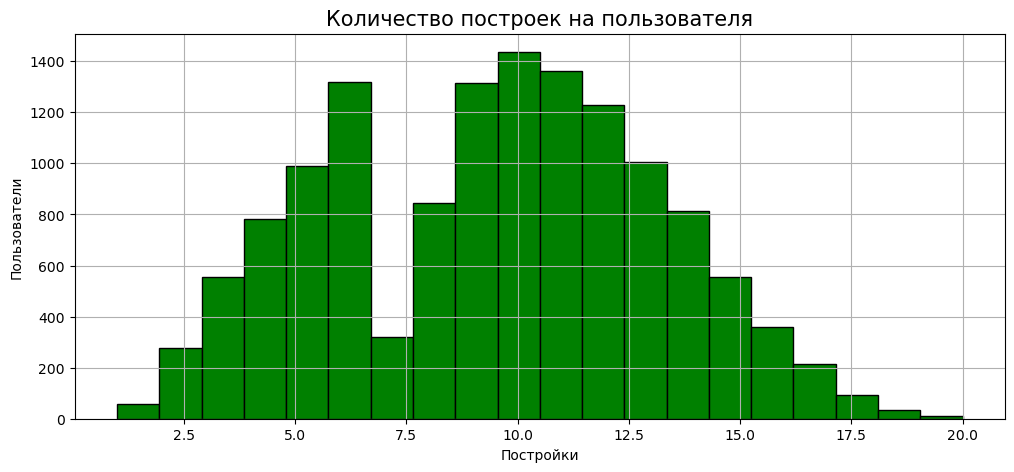

In [226]:
building(game_actions, 'all users')

Среднее число построек равно 9. На отметке 7-8 построек наблюдается спад, это может быть связано с тем, что на этой отметке пользователи переходят на новый уровень победив врага или продолжают постройку сданий дальше. Возможно, здесь так же есть игроки, которые еще в процессе прохождения уровня.

## 2.2. Анализ среднего времени, которое пользователи проводят в игре - сделано

In [227]:
# выделяем столбцы с пермыи и последним событием пользователя
first_event = game_actions.groupby(['user_id']).agg(first_event_datetime = ('event_datetime', 'min')).reset_index()
last_event = game_actions.groupby(['user_id']).agg(last_event_datetime = ('event_datetime', 'max')).reset_index()

In [228]:
# добавляем столбцы в датафрейм
game_actions = game_actions.merge(first_event, how='left', on='user_id')
game_actions = game_actions.merge(last_event, how='left', on='user_id')

In [229]:
# приводим к нужному типу
game_actions['first_event_datetime'] = game_actions['first_event_datetime'].dt.date
game_actions['last_event_datetime'] = game_actions['last_event_datetime'].dt.date

In [230]:
# добавляем столбец с лайфтаймом пользователя в игре
game_actions['lifetime'] = game_actions['last_event_datetime'] - game_actions['first_event_datetime']

In [231]:
game_actions

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
...,...,...,...,...,...,...,...,...,...
135634,2020-06-05 00:08:06,building,research_center,f21d179f-1c4b-437e-b9c6-ab1976907195,NaN,instagram_new_adverts,2020-05-06,2020-06-05,30 days
135635,2020-06-05 02:25:12,finished_stage_1,NaN,515c1952-99aa-4bca-a7ea-d0449eb5385a,NaN,yandex_direct,2020-05-07,2020-06-05,29 days
135636,2020-06-05 08:57:52,building,research_center,ed3e7d02-8a96-4be7-9998-e9813ff9c316,NaN,youtube_channel_reklama,2020-05-07,2020-06-05,29 days
135637,2020-06-05 12:12:27,finished_stage_1,NaN,32572adb-900f-4b5d-a453-1eb1e6d88d8b,NaN,facebook_ads,2020-05-07,2020-06-05,29 days


In [232]:
print('В среднем пользователи проводят в игре', game_actions['lifetime'].median())

В среднем пользователи проводят в игре 11 days 00:00:00


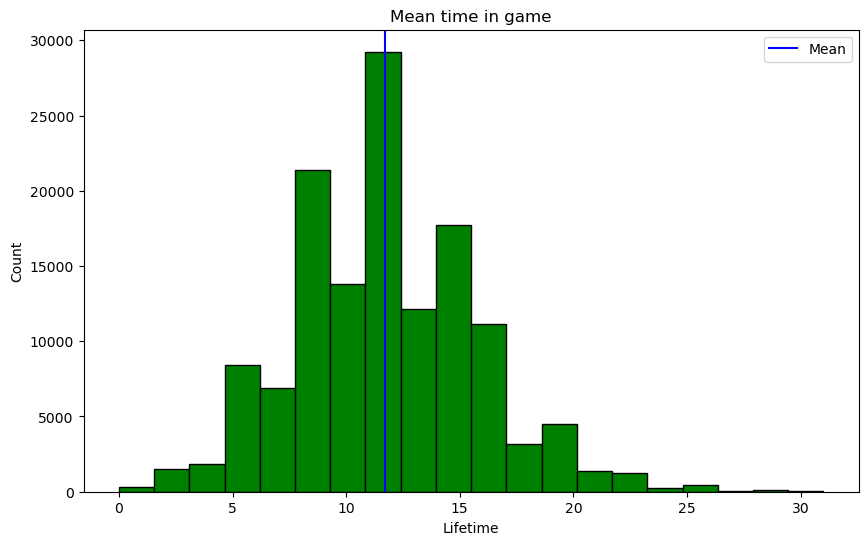

In [245]:
a = game_actions['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.title('Mean time in game')
plt.xlabel('Lifetime')
plt.ylabel('Count')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

In [125]:
# отделяем игроков, прошедших первый уровень
df_finish_level = game_actions[game_actions['event'] == 'finished_stage_1'].reset_index(drop=True)
id_finish_level = df_finish_level['user_id']

In [126]:
# игроки прошедшие первый уровень
finish_stage = game_actions.query('user_id in @id_finish_level').reset_index(drop=True)
# игроки не прошедшие первый уровень
not_finish_stage = game_actions.query('user_id not in @id_finish_level').reset_index(drop=True)

In [127]:
# игроки, закончившие уровень через проект 
project_users = finish_stage[finish_stage['event'] == 'project'].reset_index(drop=True)
project_users = project_users['user_id']

In [128]:
# игроки с уровнем, завершившие проект pve
finished_project = finish_stage.query('user_id in @project_users').reset_index(drop=True)
# игроки с уровнем, победившие врага pvp
finished_win = finish_stage.query('user_id not in @project_users').reset_index(drop=True)

In [129]:
print(finished_project['lifetime'].median(), '- среднее игровое время пользователей, завершивших 1 уровень через проект.')
print(finished_win['lifetime'].median(), '- среднее игровое время пользователей, завершивших 1 уровень через победу над врагом.')


13 days 00:00:00 - среднее игровое время пользователей, завершивших 1 уровень через проект.
11 days 00:00:00 - среднее игровое время пользователей, завершивших 1 уровень через победу над врагом.


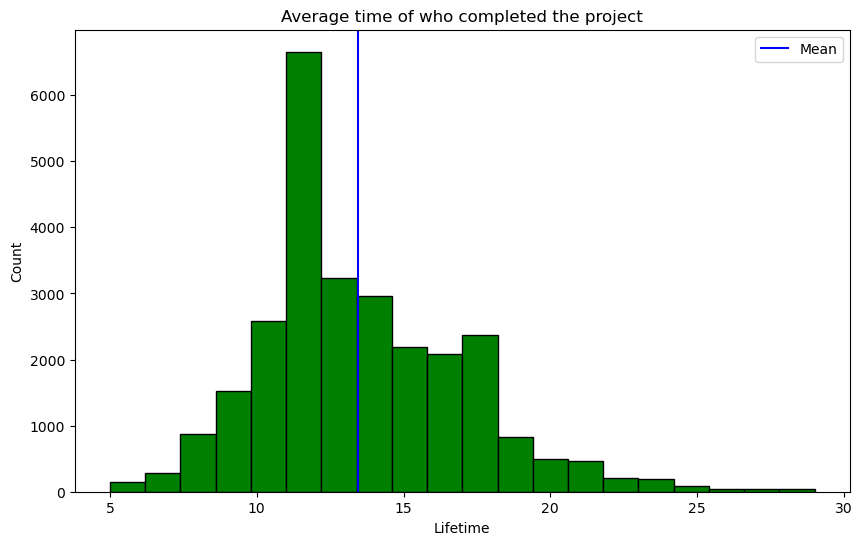

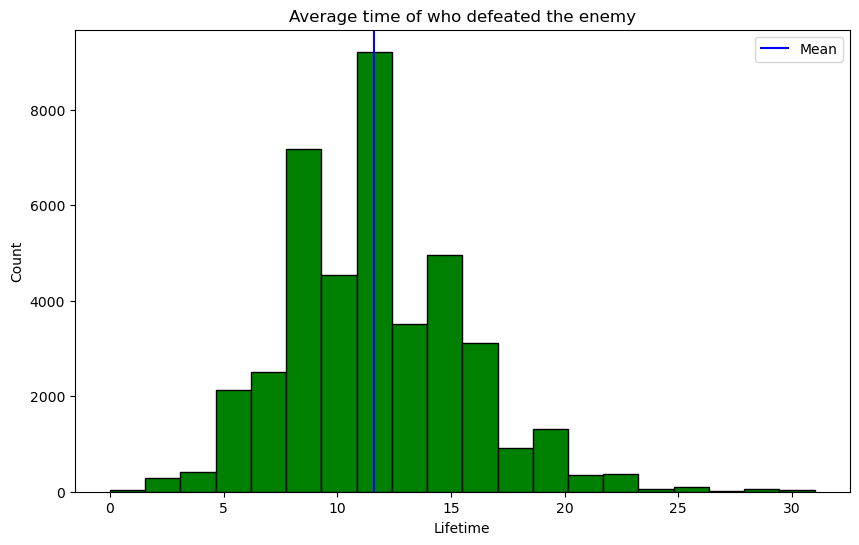

In [246]:
a = finished_project['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.xlabel('Lifetime')
plt.title('Average time of who completed the project')
plt.ylabel('Count')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

a = finished_win['lifetime'].dt.days
plt.figure(figsize=(10, 6))
plt.hist(a,color = 'green', ec = 'black', bins = 20)
plt.xlabel('Lifetime')
plt.title('Average time of who defeated the enemy')
plt.ylabel('Count')
mean_lifetime = a.mean()
plt.axvline(x=mean_lifetime, color='blue', linestyle='-', label='Mean')
plt.legend()
plt.show()

В среднем, стратегия прохождения первого уровня через победу над врагом, оказалась быстрее в реализации на 2 дня, чем стратегия проекта.

## 2.3. Анализ доли пользователей завершивших уровень - сделано

In [130]:
id_finish_level

0       ced7b368-818f-48f6-9461-2346de0892c5
1       7ef7fc89-2779-46ea-b328-9e5035b83af5
2       70db22b3-c2f4-43bc-94ea-51c8d2904a29
3       903fc9ef-ba97-4b12-9d5c-ac8d602fbd8b
4       58e077ba-feb1-4556-a5a0-d96bd04efa39
                        ...                 
5812    22cce310-fe10-41a2-941b-9c3d63327fea
5813    d477dde8-7c22-4f23-9c4f-4ec31a1aa4c8
5814    515c1952-99aa-4bca-a7ea-d0449eb5385a
5815    32572adb-900f-4b5d-a453-1eb1e6d88d8b
5816    f21d179f-1c4b-437e-b9c6-ab1976907195
Name: user_id, Length: 5817, dtype: object

In [252]:
def precent_users(df, df2):
    users = df['user_id'].nunique()
    users_2 = df2['user_id'].nunique()
    precent = users_2 / users
    return precent

In [254]:
print('Первый уровень завершили:')
print('{:.1%}'.format(precent_users(game_actions, finish_stage)))
print('Первый уровень не завершили:')
print('{:.1%}'.format(precent_users(game_actions, not_finish_stage)))

Первый уровень завершили:
42.8%
Первый уровень не завершили:
57.2%


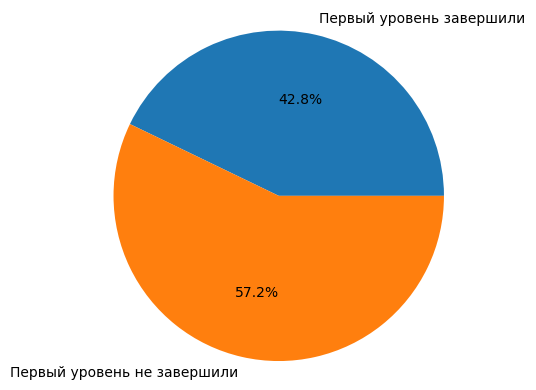

In [262]:
value1 = precent_users(game_actions, finish_stage)
value2 = precent_users(game_actions, not_finish_stage)
values = [value1, value2]
labels = ['Первый уровень завершили', "Первый уровень не завершили"]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

42.8% уровень завершили

## 2.4. Анализ долей различных стратегий в канале 

In [264]:
print('Закончили первый уровень проектом:')
print('{:.1%}'.format(precent_users(finish_stage, finished_project)))
print('Закончили первый уровень победой:')
print('{:.1%}'.format(precent_users(finish_stage, finished_win)))

Закончили первый уровень проектом:
32.1%
Закончили первый уровень победой:
67.9%


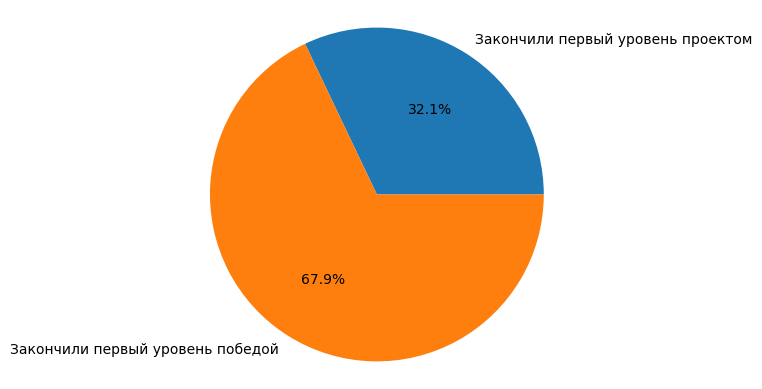

In [265]:
value1 = precent_users(finish_stage, finished_project)
value2 = precent_users(finish_stage, finished_win)
values = [value1, value2]
labels = ['Закончили первый уровень проектом', "Закончили первый уровень победой"]
plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.axis('equal')
plt.show()

2/3 игроков, которые завершили первый уровень, выбрали стратегию сражения и победы над врагом.

## Проверка 1 гипотезы

H0: время завершения уровня не различается в зависимости способа прохождения

H1: время завершения уровня различается в зависимости способа прохождения

In [94]:
from scipy import stats
finished_project['lifetime'] = finished_project['lifetime'].dt.days
finished_win['lifetime'] = finished_win['lifetime'].dt.days
t_statistic, p_value = stats.ttest_ind(finished_project['lifetime'], finished_win['lifetime'])
print("T-статистика:", t_statistic)
print("p-значение:", p_value)

T-статистика: 61.31515606383028
p-значение: 0.0


Время завершения уровня различается в зависимости способа прохождения
Получли значение t-test 61, то есть отклоняется на 61 среднекквадратичное отклонение, что очень много на самом деле, а p-value равное 0, показывает, что вероятность отклониться (то есть чтобы были примерно равны) равна 0

Нулевая гипотеза отвергается, альтернативная подтверждается

## Проверка 2 гипотезы

H0: Среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama

H1: Среднее время в игре пользователей из источника instagram_new_adverts отличается от среднего времени в игре пользователей из источника youtube_channel_reklama

In [166]:
from scipy.stats import ttest_ind
game_actions_unique = game_actions.drop_duplicates(subset='user_id')
source_X_data = game_actions_unique[game_actions_unique['source'] == 'instagram_new_adverts']['lifetime'].dt.days
source_Y_data = game_actions_unique[game_actions_unique['source'] == 'youtube_channel_reklama']['lifetime'].dt.days
t_stat, p_value = ttest_ind(source_X_data, source_Y_data, equal_var=False)
print('T-статистика:', t_stat)
print('P-значение:', p_value)

T-статистика: 1.6858508909796104
P-значение: 0.0918791932701945


T-test = 1.8392516926346225 и p-value = 0.06591910889359687, есть небольшое отклонение среднего времени в игре между пользователяит из instagram_new_adverts и youtube_channel_reklama, но оно небольшое, также наше значение p-value > 0.05 (обычный порог для подтверждения нулевой гипотезы), значит среднее время в игре пользователей из источника instagram_new_adverts равно среднему времени в игре пользователей из источника youtube_channel_reklama

Нулевая гипотеза подтверждается, альтернативная отвергается

## Вычисление метрики САС

In [152]:
ad_costs

,source,day,cost
0,facebook_ads,2020-05-03,935.882786
1,facebook_ads,2020-05-04,548.354480
2,facebook_ads,2020-05-05,260.185754
3,facebook_ads,2020-05-06,177.982200
4,facebook_ads,2020-05-07,111.766796
5,facebook_ads,2020-05-08,68.009276
6,facebook_ads,2020-05-09,38.723350
7,instagram_new_adverts,2020-05-03,943.204717
8,instagram_new_adverts,2020-05-04,502.925451
9,instagram_new_adverts,2020-05-05,313.970984


In [153]:
# всего за период с 2020-05-03 по 2020-05-09 потрачено
total_cost = ad_costs['cost'].sum()
total_cost

7603.576986788023

In [154]:
game_actions_unique = game_actions.drop_duplicates(subset='user_id')
game_actions_unique

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
...,...,...,...,...,...,...,...,...,...
78142,2020-05-10 23:34:33,building,assembly_shop,20bc9d79-10c4-4f2d-862e-4a6dece3b4ec,NaN,youtube_channel_reklama,2020-05-10,2020-05-31,21 days
78144,2020-05-10 23:34:43,building,assembly_shop,daea0325-f7c5-4008-b5f6-f89fc2c1e019,NaN,yandex_direct,2020-05-10,2020-05-10,0 days
78234,2020-05-10 23:44:17,building,assembly_shop,7b225969-375a-455e-a14a-ed1ab373fb65,NaN,instagram_new_adverts,2020-05-10,2020-05-24,14 days
78385,2020-05-10 23:57:56,building,assembly_shop,cafd1b8b-507b-49ae-abf0-89fe863a8b03,NaN,facebook_ads,2020-05-10,2020-05-18,8 days


In [158]:
start_date = pd.to_datetime('2020-05-03')
end_date = pd.to_datetime('2020-05-09')
filtered_game_actions_unique = game_actions_unique[(game_actions_unique['first_event_datetime'] >= start_date) & (game_actions_unique['first_event_datetime'] <= end_date)]
filtered_game_actions_unique

,event_datetime,event,building_type,user_id,project_type,source,first_event_datetime,last_event_datetime,lifetime
0,2020-05-04 00:00:01,building,assembly_shop,55e92310-cb8e-4754-b622-597e124b03de,NaN,youtube_channel_reklama,2020-05-04,2020-05-10,6 days
1,2020-05-04 00:00:03,building,assembly_shop,c07b1c10-f477-44dc-81dc-ec82254b1347,NaN,facebook_ads,2020-05-04,2020-05-15,11 days
2,2020-05-04 00:00:16,building,assembly_shop,6edd42cc-e753-4ff6-a947-2107cd560710,NaN,instagram_new_adverts,2020-05-04,2020-05-16,12 days
3,2020-05-04 00:00:16,building,assembly_shop,92c69003-d60a-444a-827f-8cc51bf6bf4c,NaN,facebook_ads,2020-05-04,2020-05-12,8 days
4,2020-05-04 00:00:35,building,assembly_shop,cdc6bb92-0ccb-4490-9866-ef142f09139d,NaN,yandex_direct,2020-05-04,2020-05-11,7 days
...,...,...,...,...,...,...,...,...,...
63108,2020-05-09 23:50:21,building,assembly_shop,117ce7a1-41e5-41b1-bedf-7e12940a2c34,NaN,youtube_channel_reklama,2020-05-09,2020-05-19,10 days
63112,2020-05-09 23:50:42,building,assembly_shop,7598633d-2111-4a2c-ada1-a6dcc25b7b9a,NaN,yandex_direct,2020-05-09,2020-05-11,2 days
63139,2020-05-09 23:54:15,building,assembly_shop,9aa4655a-2fe4-40e0-9976-7686d2d6e489,NaN,instagram_new_adverts,2020-05-09,2020-05-15,6 days
63143,2020-05-09 23:54:23,building,assembly_shop,afa1f9b4-818d-4c77-b9b1-4019d516292c,NaN,instagram_new_adverts,2020-05-09,2020-05-12,3 days


In [159]:
CAC = total_cost/filtered_game_actions_unique.shape[0]
CAC

0.571482674692824